# Breast Ultrasound Image Segmentation using U-Net

In [37]:
import sys
# python version
print(sys.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]


In [ ]:
!nvidia-smi
!nvcc --version

In [36]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
aiohttp                      3.8.3
aiosignal                    1.3.1
altair                       4.2.2
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6
branca                       0.5.0
cachetools                   5.2.1
catboost                     1.1.1
category-encoders            2.5.1.post0
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
click                        8.1.3
click-plugins                1.1.1
cligj                        0.7.2

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Importing Libraries

In [38]:
import os
import time
import shutil
from glob import glob

import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as ks
from tensorflow import image as tfi
from keras import layers
from keras import models
from keras import optimizers
from keras import utils

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from keras.optimizers import Adam, Adamax

from tf_explain.core.grad_cam import GradCAM
from keras.metrics import MeanIoU


from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

sns.set_style('darkgrid')

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", ks.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Seaborn version: ", sns.__version__)
print("OpenCV version: ", cv2.__version__)
print("Pillow version: ", PIL.__version__)
print("All libraries imported successfully!")

Tensorflow version:  2.12.0
Keras version:  2.12.0
Pandas version:  2.0.3
Numpy version:  1.23.5
Seaborn version:  0.12.2
OpenCV version:  4.7.0
Pillow version:  9.5.0
All libraries imported successfully!


In [6]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


## Importing Dataset

We load the dataset and categorize it accordingly into different lists based on the type of image.

We use cv2 to read them into arrays

In [4]:
image_dir = './Dataset_BUSI_with_GT/'

benign_images = []
malignant_images = []
normal_images = []

def load_images_from_folder(folder, category):
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                if category == 'benign':
                    benign_images.append(img)
                elif category == 'malignant':
                    malignant_images.append(img)
                elif category == 'normal':
                    normal_images.append(img)

load_images_from_folder(os.path.join(image_dir, 'benign'), 'benign')
load_images_from_folder(os.path.join(image_dir, 'malignant'), 'malignant')
load_images_from_folder(os.path.join(image_dir, 'normal'), 'normal')

In [5]:
benign_labels = np.zeros(len(benign_images))
malignant_labels = np.ones(len(malignant_images))
normal_labels = np.full(len(normal_images), 2)

images = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
labels = np.concatenate((benign_labels, malignant_labels, normal_labels), axis=0)

print("Total number of images: ", len(images))
print("Total number of labels: ", len(labels))

Total number of images:  1578
Total number of labels:  1578


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Image Size

In [6]:
print("Benign Images:", len(benign_images))
print("Malignant Images:", len(malignant_images))
print("Normal Images:", len(normal_images))

print("Number of Benign ultrasound data (no mask):", len(benign_images)/2)
print("Number of Malignant ultrasound data (no mask):", len(malignant_images)/2)
print("Number of Normal ultrasound data (no mask):", len(normal_images)/2)

Benign Images: 891
Malignant Images: 421
Normal Images: 266
Number of Benign ultrasound data (no mask): 445.5
Number of Malignant ultrasound data (no mask): 210.5
Number of Normal ultrasound data (no mask): 133.0


In [7]:
benign_images[0][0][0]

array([7, 7, 7], dtype=uint8)

## Displaying Images

In [ ]:
# # function to display images
# def display_images(images, labels, title, cmap=None):
#     fig = plt.figure(figsize=(15, 15))
#     for i in range(9): # update range to 9
#         ax = fig.add_subplot(3, 3, i+1) # update subplot index to i+1
#         ax.imshow(images[i], cmap=cmap)
#         ax.set_title(f'{labels[i]} ({i+1})') # update title to include index number
#         ax.axis('off')
#     plt.suptitle(title, fontsize=20)
#     plt.show()

# # display the first benign images with their labels
# display_images(benign_images, ['Benign'] * 9, 'Benign Images')


In [ ]:
# # display the first malignant images with their labels
# display_images(malignant_images, ['Malignant'] * 9, 'Malignant Images')

In [ ]:
# # display the first normal images with their labels
# display_images(normal_images, ['Normal'] * 9, 'Normal Images')

---

---

In [8]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [9]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

SIZE = 256

In [10]:
root_path = './Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [11]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])
triple_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_2.png")) for name in classes])

In [12]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

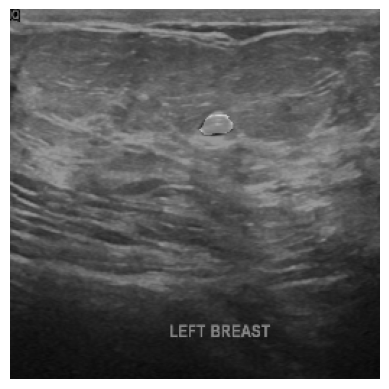

In [13]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE))

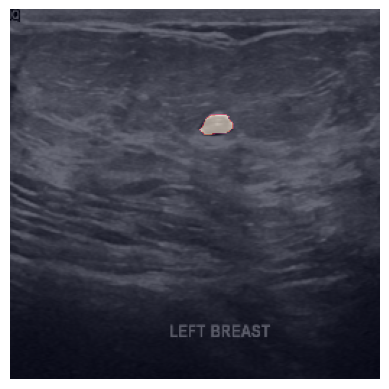

In [14]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

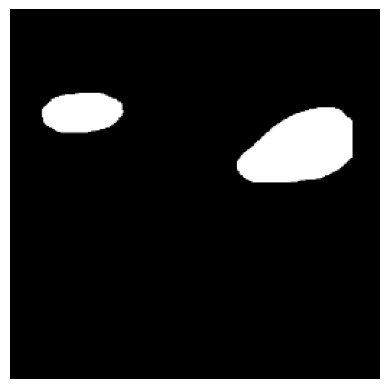

In [15]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('./Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('./Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

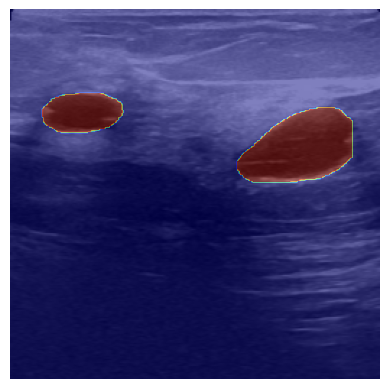

In [16]:
show_image(load_image('./Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

In [17]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

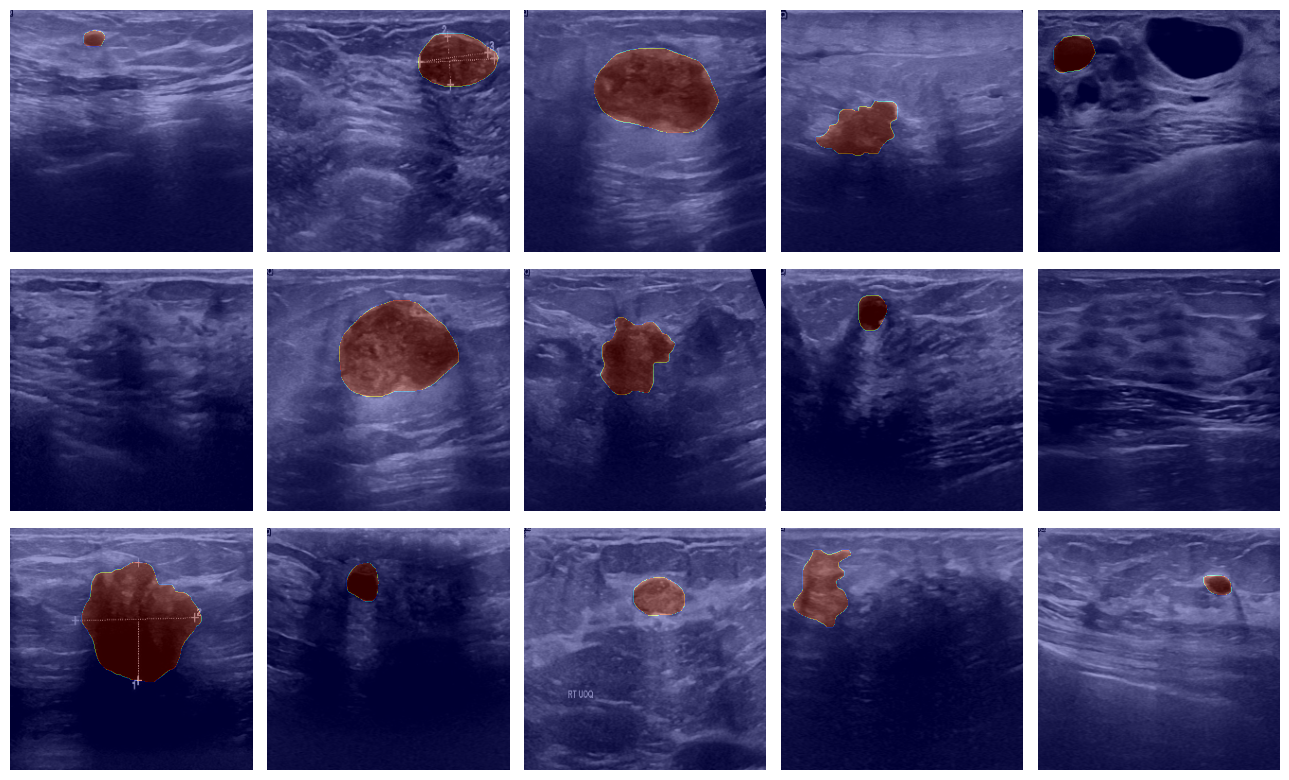

In [18]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

In [19]:
# implementing attention gate and unet
# Input(256, 256, 3) function
import tensorflow as tf
from tensorflow import keras as ks

def Input(shape):
    inputs = ks.Input(shape)
    return inputs

def attention_block_2d(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1])(x) # 1x1 convolution
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1])(g) # 1x1 convolution
    f = Activation('relu')(Add()([theta_x, phi_g])) # element-wise addition. followed by relu will give attention map
    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f) 
    rate = Activation('sigmoid')(psi_f) # attention map. sigmoid gives values between 0 and 1 and will give weights to the corresponding pixels
    att_x = Multiply()([x, rate]) 
    return att_x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv

def encoder_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    return conv

def decoder_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    return conv

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    return conv


def UNet(input_shape):
    inputs = Input(input_shape)
    # encoder
    enc1 = encoder_block(inputs, 64, kernel_size=(3, 3), padding="same", strides=1)
    pool1 = MaxPool2D((2, 2))(enc1)
    enc2 = encoder_block(pool1, 128, kernel_size=(3, 3), padding="same", strides=1)
    pool2 = MaxPool2D((2, 2))(enc2)
    enc3 = encoder_block(pool2, 256, kernel_size=(3, 3), padding="same", strides=1)
    pool3 = MaxPool2D((2, 2))(enc3)

    # bottleneck
    bottleneck = bottleneck_block(pool3, 512, kernel_size=(3, 3), padding="same", strides=1)

    # decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    att1 = attention_block_2d(enc3, up1, 256)
    concat1 = concatenate([up1, att1], axis=-1)
    dec1 = decoder_block(concat1, 256, kernel_size=(3, 3), padding="same", strides=1)
    up2 = UpSampling2D((2, 2))(dec1)
    att2 = attention_block_2d(enc2, up2, 128)
    concat2 = concatenate([up2, att2], axis=-1)
    dec2 = decoder_block(concat2, 128, kernel_size=(3, 3), padding="same", strides=1)
    up3 = UpSampling2D((2, 2))(dec2)
    att3 = attention_block_2d(enc1, up3, 64)
    concat3 = concatenate([up3, att3], axis=-1)
    dec3 = decoder_block(concat3, 64, kernel_size=(3, 3), padding="same", strides=1)

    # output
    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(dec3)

    model = Model(inputs, output)
    return model

model = UNet((256, 256, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [60]:
!pip install keras matplotlib graphviz 
!pip install pydot pydotplus

In [61]:
from keras.utils import plot_model
import pydot
import pydotplus
import graphviz

In [62]:
# generate the plot of model architecture

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Encoder

In [51]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

## Decoder

In [52]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }


## Attention Gate

In [53]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }


## Custom Callback

In [55]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

## Attention U-Net

In [56]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

In [57]:
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Training

In [59]:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Training

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=38)

# configure model
BATCH_SIZE = 16
SPE = len(X_train) // BATCH_SIZE

# Training
results = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

Epoch 1/5
39/39 [==============================] - 640s 16s/step - loss: 0.4285 - accuracy: 0.8622 - IoU: 0.4607 - val_loss: 0.4367 - val_accuracy: 0.9202 - val_IoU: 0.4612
Epoch 2/5
12/39 [========>.....................] - ETA: 7:25 - loss: 0.2420 - accuracy: 0.9161 - IoU: 0.4592

KeyboardInterrupt: 

In [31]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

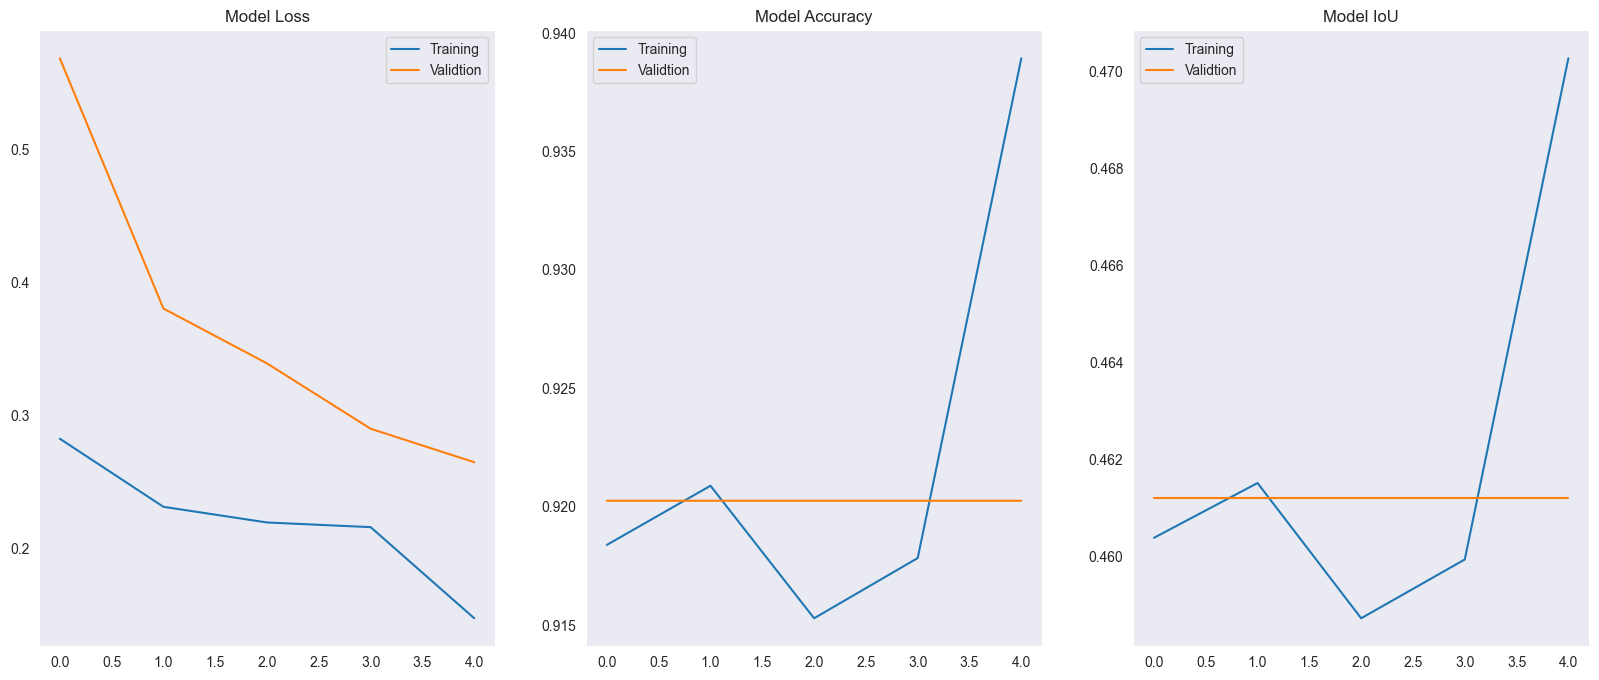

In [32]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 [==============================] - 0s 182ms/step


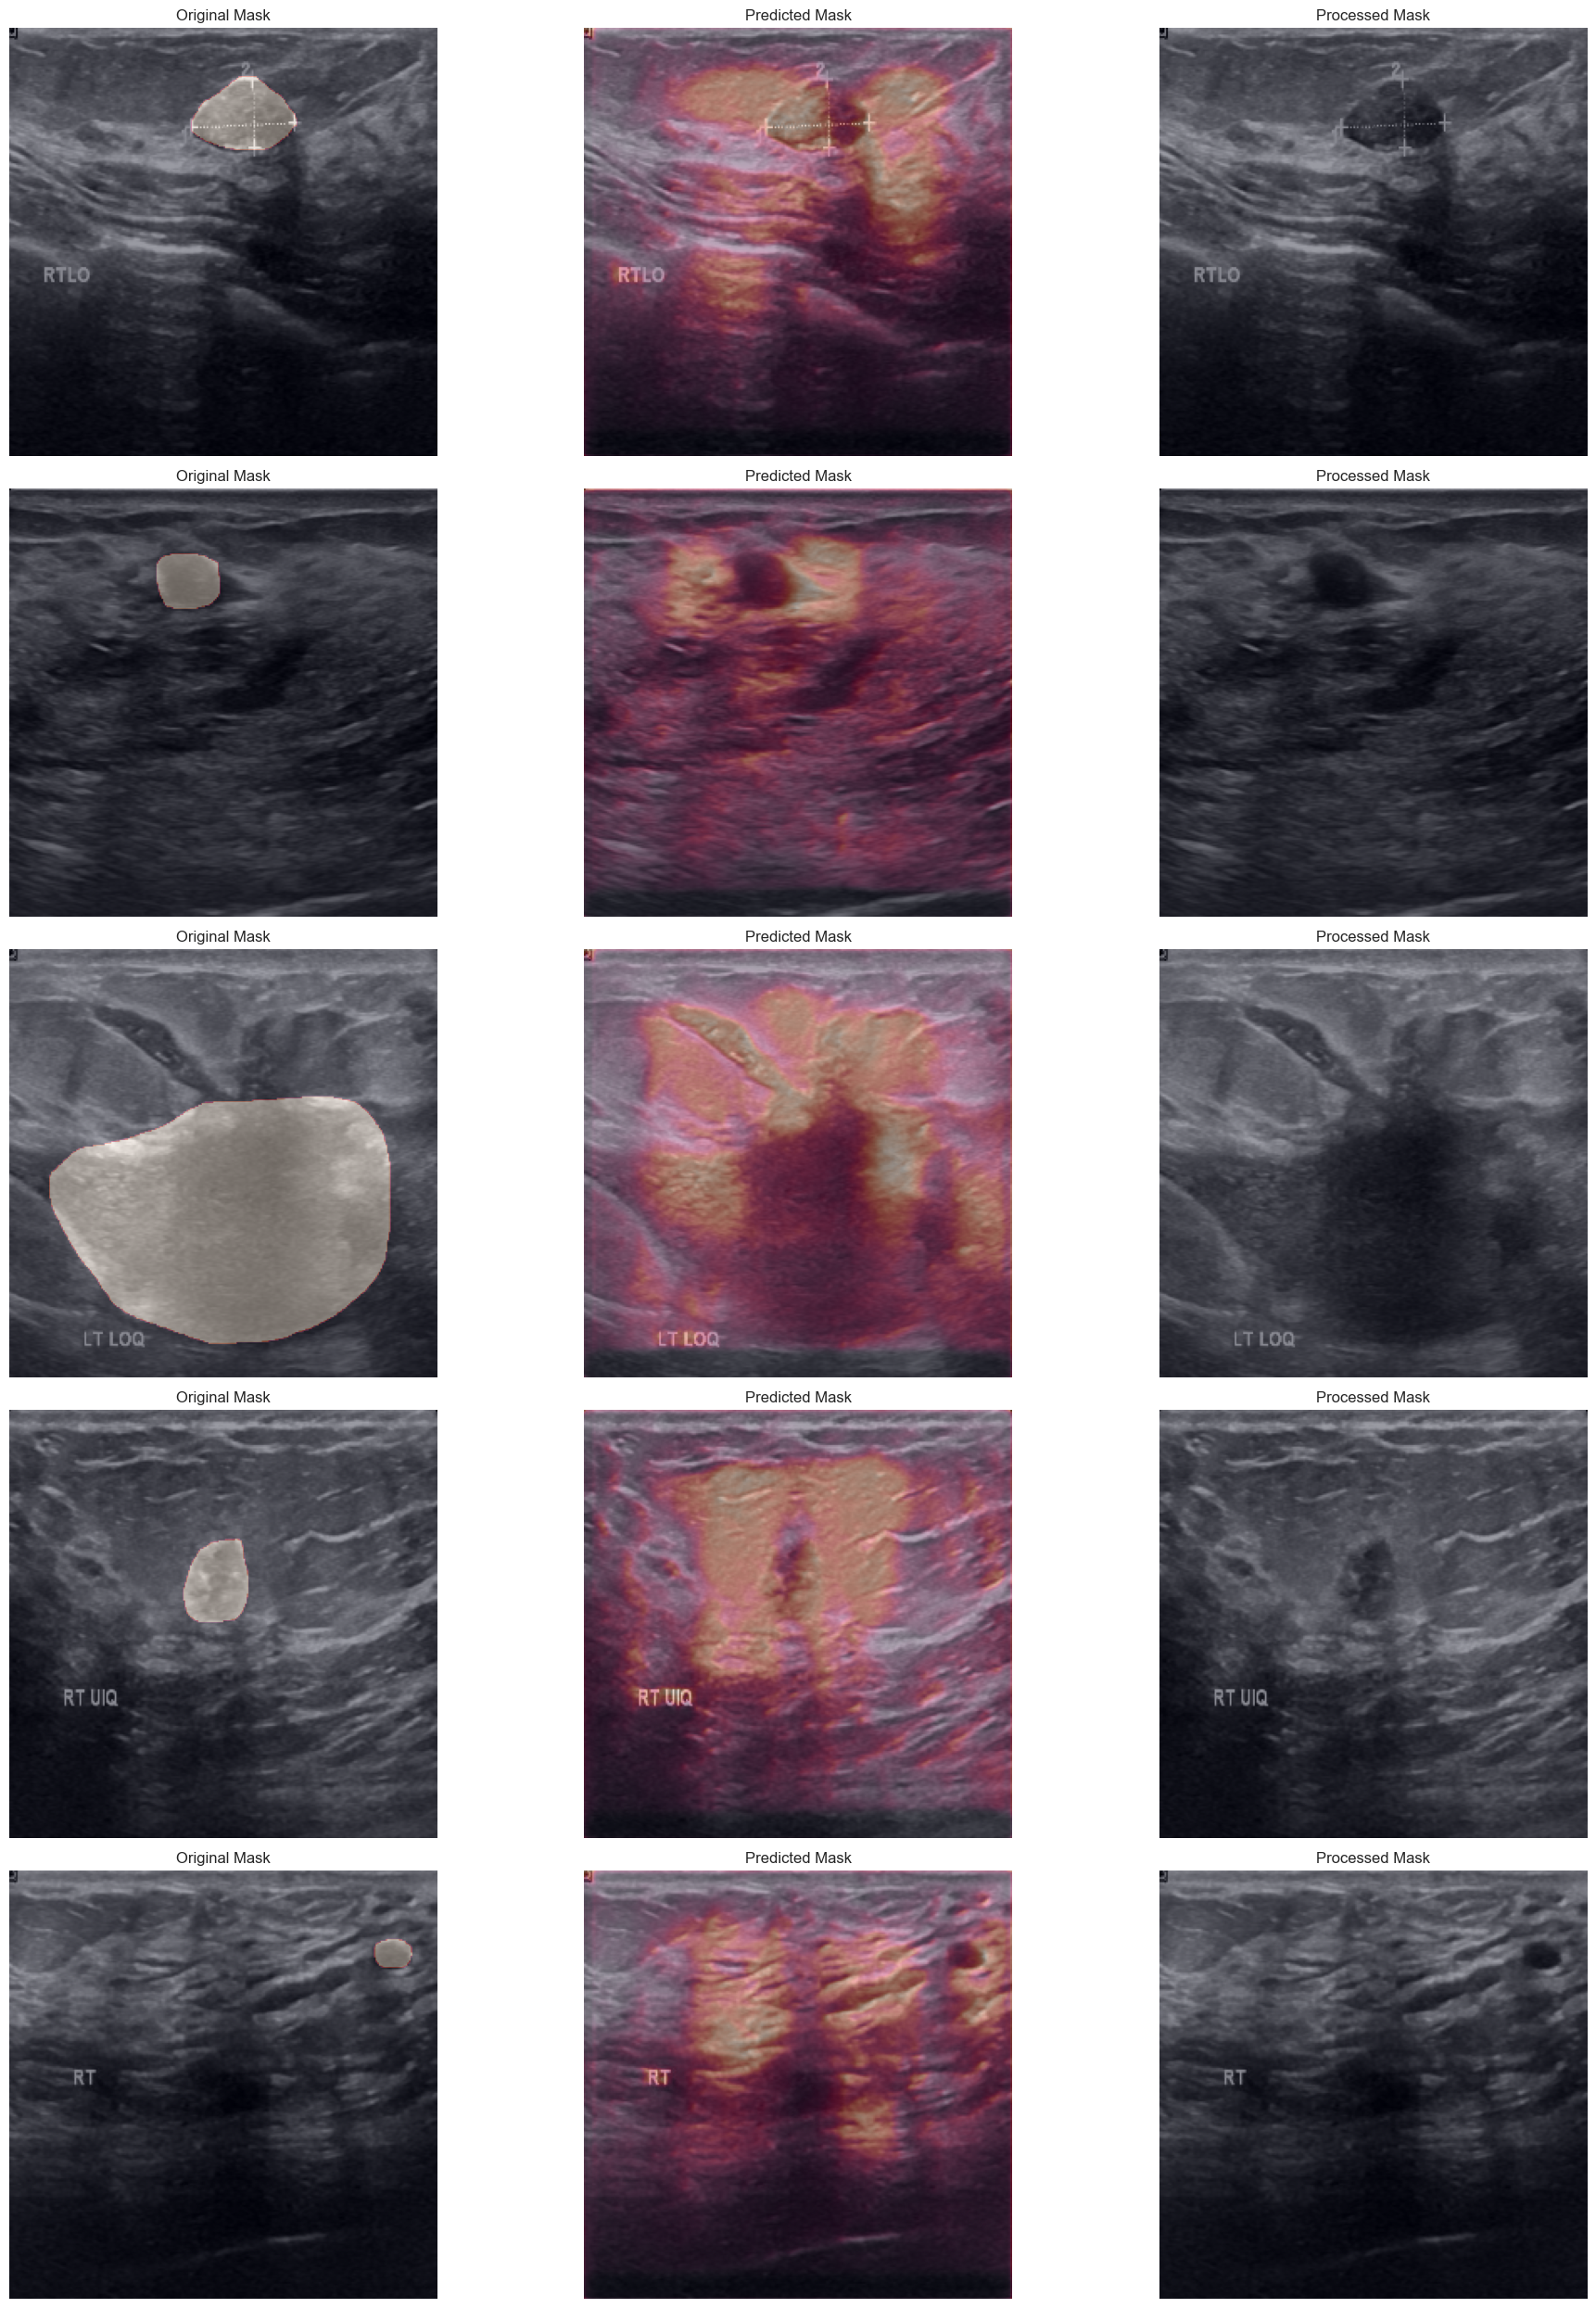

In [33]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()